# Healthcare Ticketing Topic Classification #

## Prepare Tools ##

In [42]:
# utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
########

# text pre-processing
import nltk # natural language processing
from nltk.corpus import stopwords, wordnet # stop words
# from nltk.stem.snowball import SnowballStemmer # stemming
from nltk import pos_tag, word_tokenize # identify POS tag, required by lemmatizer
from nltk.stem import WordNetLemmatizer # lemmatization
########

# extraction
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
########

from sklearn.model_selection import train_test_split
########

# deep learning
# simple multilayer perceptron
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

# LSTM
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# overfitting remedy
from keras import regularizers
########

# performance
from sklearn.metrics import confusion_matrix
########

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

In [2]:
working_dir = "/home/lee/Documents/Datasets for GitHub/kaggle-healthcare-ticketing-system/"

# download to working directory
nltk.download(['stopwords', 'wordnet', 'punkt', 'averaged_perceptron_tagger'], download_dir=working_dir)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lee/Documents/Datasets for GitHub/kaggle-
[nltk_data]     healthcare-ticketing-system/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lee/Documents/Datasets for GitHub/kaggle-
[nltk_data]     healthcare-ticketing-system/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lee/Documents/Datasets
[nltk_data]     for GitHub/kaggle-healthcare-ticketing-system/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lee/Documents/Datasets for GitHub/kaggle-
[nltk_data]     healthcare-ticketing-system/...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load and Inspect Data ##

In [3]:
df = pd.read_csv(working_dir+'train.csv')

In [4]:
print("dataframe shape: {}".format(df.shape))
print("\n")
print("preview: \n{}".format(df.head()))
print("\n")
print("first 5 conversations:")
for i in list(range(5)):
    print(str(i)+" "+df.loc[i, 'converse']+"\n")

dataframe shape: (48699, 2)


preview: 
              categories                                           converse
0  QUERIES FROM PHARMACY  please to verify instructions for drugname pat...
1        NEW APPOINTMENT  lmovm for patients mother to and schd rov trac...
2                 OTHERS  labtype and insurance approval other incoming ...
3                 OTHERS  clinical list changes medfusion secure electro...
4     MEDICATION RELATED  wants to wean off medication work phone name d...


first 5 conversations:
0 please to verify instructions for drugname patients wi from pharmacy target reason for call details please to verify instructions for drugname patients will be picking up Rx timephrase clarified Rx with pharmacy lisa gilligan rn

1 lmovm for patients mother to and schd rov tracy dominguez am kellee currie pm rhonda fanning

2 labtype and insurance approval other incoming name lpn clinical review for cigna reason for call details to inform that there is not enough informati

Observations:
* No punctuations.
* Names are prevalent. 
* There are many abbreviations I cannot decipher. Providers are likely to use the same abbreviations though so this ought not to be a problem. 
* Many terms are masked for confidentiality reasons, such as "drugname" and "timephrase". 

### Check for Missing ###

In [5]:
print('Is any "converse" missing?', df['converse'].isnull().values.any())

Is any "converse" missing? True


### Check Class Balance ###

In [6]:
print("# of unique categories: {}".format(df["categories"].nunique()))
print("\n")
print("unique categories: {}".format(set(df["categories"])))
print("\n")
print("label frequencies: \n{}".format(df["categories"].value_counts()))

# of unique categories: 21


unique categories: {'MEDICATION RELATED', 'CHANGE OF HOSPITAL', 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)', 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)', 'JUNK', 'QUERIES FROM INSURANCE FIRM', 'REFILL', 'CHANGE OF PHARMACY', 'QUERIES FROM PHARMACY', 'CHANGE OF PROVIDER', 'LAB RESULTS', 'OTHERS', 'CANCELLATION', 'SYMPTOMS', 'PROVIDER', 'RESCHEDULING', 'FOLLOW UP ON PREVIOUS REQUEST', 'NEW APPOINTMENT', 'PRIOR AUTHORIZATION', 'QUERY ON CURRENT APPOINTMENT', 'RUNNING LATE TO APPOINTMENT'}


label frequencies: 
MEDICATION RELATED                               9010
NEW APPOINTMENT                                  8907
REFILL                                           8347
OTHERS                                           6253
SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)    3018
LAB RESULTS                                      2253
PROVIDER                                         1677
QUERIES FROM PHARMACY                            1464
RESCHEDULING         

Classes are relatively well balanced. However I (admittedly not an expert on categorizing tickets) see overlaps among the categories. Now look at a few conversations to check for overlapping.

In [7]:
print(df.iloc[40, 0])
print(df.iloc[40, 1])
print("\n")
print(df.iloc[59, 0])
print(df.iloc[59, 1])
print("\n")
print(df.iloc[61, 0])
print(df.iloc[61, 1])

SYMPTOMS
fyi increased numbness phone patient triage adult numbness in any part of the body patients and states that shes having increased numbness in her left leg and ankle please back to advise timephrase pm started timephrase got worst on sunday has not changed since feels she is having a flair feels as if tournique on left ankle appointment scheduled for phone completed appointment scheduled patient mary morton lpn timephrase pm


MEDICATION RELATED
patients now experiencing numbness to rt side patient triage adult patients is still taking prednisone as prescribed patients is now experiencing numbness to rt side of her forehead down the rt side of her face to her rt forearm her labtype is scheduled for in the timephrase noted proceed with labtype can always check and see if there are openings timephrase to get her in sooner stacey carroll anp rna follow rn labtype department to check availability for timephrase they do not have openings for a double labtype notified patients of sta

All the 3 conversations involve patients reporting numbness in detail. But record 40 is categorized as "SYMPTOMS" and 59 and 61 "MEDICATION RELATED". I wonder how strong the agreement will be between two human experts categorizing the same tickets - if the performance of the model does not turn up high I will not be surprised.

## Preprocess the Text ##

In [8]:
nltk.data.path.append(working_dir)

# replace NaN
df['converse_filled'] = df['converse'].fillna(value=' ')

# remove punctuation
df['removepunc'] = df['converse_filled'].str.replace('[^\w\s]',' ')

# lower casing
df['lower'] = df['removepunc'].str.lower()

# tokenize and lemmatize
# adjective, adverb, noun, verb = 'JJ', 'RB', 'NN', 'VB'
map_pos = {'NN': 'n', 'JJ': 'a', 'RB': 'r', 'VB': 'v'}

def lemmatize_after_pos(review):
    lemma_review = []
    for word, tag in pos_tag(word_tokenize(review)):
        wntag = tag[0:2]
        wntag = map_pos[wntag] if wntag in ['NN', 'JJ', 'RB', 'VB'] else None
        lemma = WordNetLemmatizer().lemmatize(word, wntag) if wntag else word
        lemma_review.append(lemma)
    return lemma_review

df['lemmatized'] = df['lower'].apply(lambda x: lemmatize_after_pos(x))

# remove stopwords
stop = stopwords.words('english')
df['removestop'] = df['lemmatized'].apply(lambda x: [item for item in x if item not in stop])

df['processed_converse'] = df['removestop'].apply(lambda x: ' '.join(x))

In [9]:
print("inspect results:")
for i in list(range(5)):
    print(i, df.loc[i, 'processed_converse'])

inspect results:
0 please verify instruction drugname patient wi pharmacy target reason call detail please verify instruction drugname patient pick rx timephrase clarify rx pharmacy lisa gilligan rn
1 lmovm patient mother schd rov tracy dominguez kellee currie pm rhonda fanning
2 labtype insurance approval incoming name lpn clinical review cigna reason call detail inform enough information provide patient approve home labtype whitney fax need fill send question please whintey rna follow rout wendy upchurch lisa mohamed rn auth obtain rout sleep scheduler tammy byrd fyi wendy upchurch clinical list change
3 clinical list change medfusion secure electronic message subject genetic testing hello jennifer want update stand far genetic testing concern work build standard order test testing administer ground floor building next door see today contact order send able obtain cost estimate look forward speak soon angela cma end message body route response ansmith notify read failure notice day m

We need to have an idea of the length of conversations to bound conversations for a future step, then longer ones will be truncated and shorter ones zero-padded. 

In [10]:
print("distribution of word counts:\n{}".format(df['processed_converse'].str.len().describe()))
print("95th, 99th, 99.9th percentiles: {}".format(np.percentile(df['processed_converse'].str.len(), [95, 99, 99.9])))

distribution of word counts:
count    48699.000000
mean       353.912996
std        211.505234
min          0.000000
25%        177.000000
50%        319.000000
75%        532.000000
max       1738.000000
Name: processed_converse, dtype: float64
95th, 99th, 99.9th percentiles: [703. 794. 940.]


## Prepare Training Dataset ##

In [11]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df['processed_converse'], \
                                                                df["categories"], \
                                                                test_size=0.1, random_state=0);

How many unique words are there in the training dataset? Their frequencies?

In [12]:
all_words_count = dict(Counter(" ".join(df_X_train.values.tolist()).split(" ")).items())

Look at words with low frequencies.

In [13]:
print({(k, v) for k, v in all_words_count.items() if v < 5})

{('aboutmedication', 1), ('chukwurah', 2), ('palvix', 1), ('reitterated', 1), ('radicular', 2), ('stationary', 3), ('concussi', 1), ('carbamezapine', 1), ('theyhave', 1), ('sawdr', 1), ('vertigodizziness', 1), ('actiion', 1), ('welch', 2), ('tratrums', 1), ('ambie', 1), ('illegible', 4), ('topamaxmaxalt', 1), ('fairwoods', 2), ('arises', 1), ('approvedquantity', 1), ('txing', 2), ('yoo', 1), ('soundbut', 2), ('betaserone', 4), ('ophthamologist', 3), ('pateitn', 2), ('hawk', 1), ('chaged', 2), ('besty', 2), ('vaccinationphysical', 2), ('volteran', 1), ('dicplofen', 1), ('eastpointe', 3), ('edgewater', 2), ('kgdolan', 1), ('josiah', 1), ('capules', 2), ('ure', 1), ('scheduleadvise', 4), ('ler', 1), ('uotient', 1), ('underarms', 1), ('preferable', 3), ('perrill', 1), ('nicolerecurrent', 1), ('lozano', 1), ('valum', 1), ('simpsonville', 1), ('puffiness', 1), ('maldonado', 2), ('concussionbaselin', 1), ('unhapppy', 1), ('passr', 3), ('diazepamaleve', 1), ('shandel', 1), ('opthal', 2), ('ncv

We can see that most of these are misspellings; some are rare names. 

In [14]:
remove_low_freq_words = [k for k, v in dict(all_words_count).items() if v >= 5]
print("potential vocabulary size: {}".format(len(remove_low_freq_words)))

potential vocabulary size: 7902


In [44]:
vocab_size = (2**np.ceil(np.log(len(remove_low_freq_words))/np.log(2))).astype(np.int64)
tokenize = Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(df_X_train)

X_train = tokenize.texts_to_sequences(df_X_train)
X_test = tokenize.texts_to_sequences(df_X_test)

# truncate and pad input sequences
max_converse_length = 768
X_train = sequence.pad_sequences(X_train, maxlen=max_converse_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_converse_length)

Transform the labels.

In [45]:
encoder = LabelBinarizer()
encoder.fit(df_y_train)
y_train = encoder.transform(df_y_train)
y_test = encoder.transform(df_y_test)

The mapping between actual topics and their encoded representation:

In [19]:
# key is textual topics, value is numerical matrix
y_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

## Define and Fit Models ##

In [20]:
batch_size = 32
epochs = 16 # 128
embedding_vecor_length = 32
num_classes = len(encoder.classes_)

### Simple Multi-Layer Perceptron Model ###

#### Train Model ####

In [46]:
print('Building model, with dropout layer, no regularization...')
model = Sequential()

model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_converse_length))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Building model, with dropout layer, no regularization...
Train on 39446 samples, validate on 4383 samples
Epoch 1/16
39446/39446 [==============================] - 211s 5ms/step - loss: 1.3512 - acc: 0.5901 - val_loss: 0.9902 - val_acc: 0.6833
Epoch 2/16
39446/39446 [==============================] - 205s 5ms/step - loss: 0.8480 - acc: 0.7275 - val_loss: 0.9569 - val_acc: 0.6988
Epoch 3/16
39446/39446 [==============================] - 206s 5ms/step - loss: 0.6183 - acc: 0.7956 - val_loss: 1.0299 - val_acc: 0.6929
Epoch 4/16
39446/39446 [==============================] - 202s 5ms/step - loss: 0.4189 - acc: 0.8612 - val_loss: 1.1543 - val_acc: 0.6861
Epoch 5/16
39446/39446 [==============================] - 201s 5ms/step - loss: 0.2797 - acc: 0.9080 - val_loss: 1.3773 - val_acc: 0.6838
Epoch 6/16
39446/39446 [==============================] - 207s 5ms/step - loss: 0.1969 - acc: 0.9342 - val_loss: 1.5610 - val_acc: 0.6815
Epoch 7/16
39446/39446 [==============================] - 201s 5ms

#### Visualize Training History ####

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


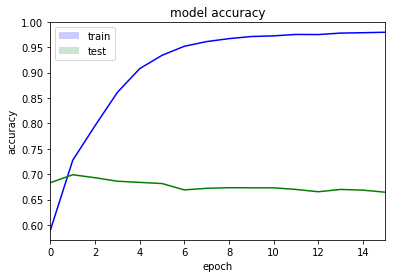

In [47]:
def summarize_history(model_history):
    sns.tsplot(model_history.history['acc'], color='blue').set_title('model accuracy')
    sns.tsplot(model_history.history['val_acc'], color='green')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

summarize_history(history)

Looks like the model overfits the data even with a dropout layer. Next we try adding regularization as a remedy for overfitting. 

#### Train Model with L2 Regularization Added ####

In [101]:
print('Building model, dropout layer, L2 regularization...')
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_converse_length))
model2.add(Flatten())
model2.add(Dense(512, input_shape=(vocab_size,), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model2.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Building model, dropout layer, L2 regularization...
Train on 39446 samples, validate on 4383 samples
Epoch 1/16
39446/39446 [==============================] - 262s 7ms/step - loss: 2.0377 - acc: 0.5215 - val_loss: 1.7694 - val_acc: 0.6055
Epoch 2/16
39446/39446 [==============================] - 253s 6ms/step - loss: 1.7386 - acc: 0.6343 - val_loss: 1.7453 - val_acc: 0.6452
Epoch 3/16
39446/39446 [==============================] - 255s 6ms/step - loss: 1.6724 - acc: 0.6695 - val_loss: 1.7461 - val_acc: 0.6578
Epoch 4/16
39446/39446 [==============================] - 249s 6ms/step - loss: 1.6572 - acc: 0.6852 - val_loss: 1.7250 - val_acc: 0.6639
Epoch 5/16
39446/39446 [==============================] - 254s 6ms/step - loss: 1.6379 - acc: 0.6967 - val_loss: 1.7841 - val_acc: 0.6642
Epoch 6/16
39446/39446 [==============================] - 254s 6ms/step - loss: 1.6403 - acc: 0.7074 - val_loss: 1.7682 - val_acc: 0.6724
Epoch 7/16
39446/39446 [==============================] - 254s 6ms/step

#### Visualize Training History ####

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


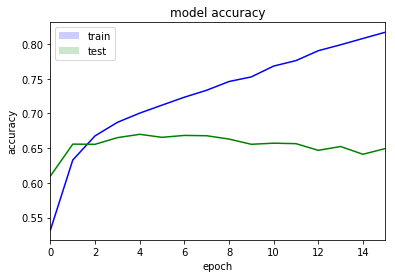

In [49]:
summarize_history(history2)

The performance is similar to the previous model. 

For which categories does the model make wrong predictions?

#### Produce Confusion Matrix ####

In [50]:
def plot_confusion_matrix(model):
    prediction = model.predict(X_test, batch_size=batch_size)
    predicted_label = encoder.classes_[np.argmax(prediction, axis=1)]

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(df_y_test, predicted_label)
    # normalize confusion matrix as classes are not balanced
    cnf_matrix_normalized = cnf_matrix/cnf_matrix.sum(axis=1)[:, np.newaxis]
    # heatmap 
    plt.figure(figsize = (20, 15))
    sns.heatmap(cnf_matrix_normalized, cmap="GnBu", linewidths=0.1, linecolor='gray', \
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)

    plt.ylabel('True category', fontsize=25)
    plt.xlabel('Predicted category', fontsize=25)

    plt.title("Normalized Confusion Matrix", fontsize=30)

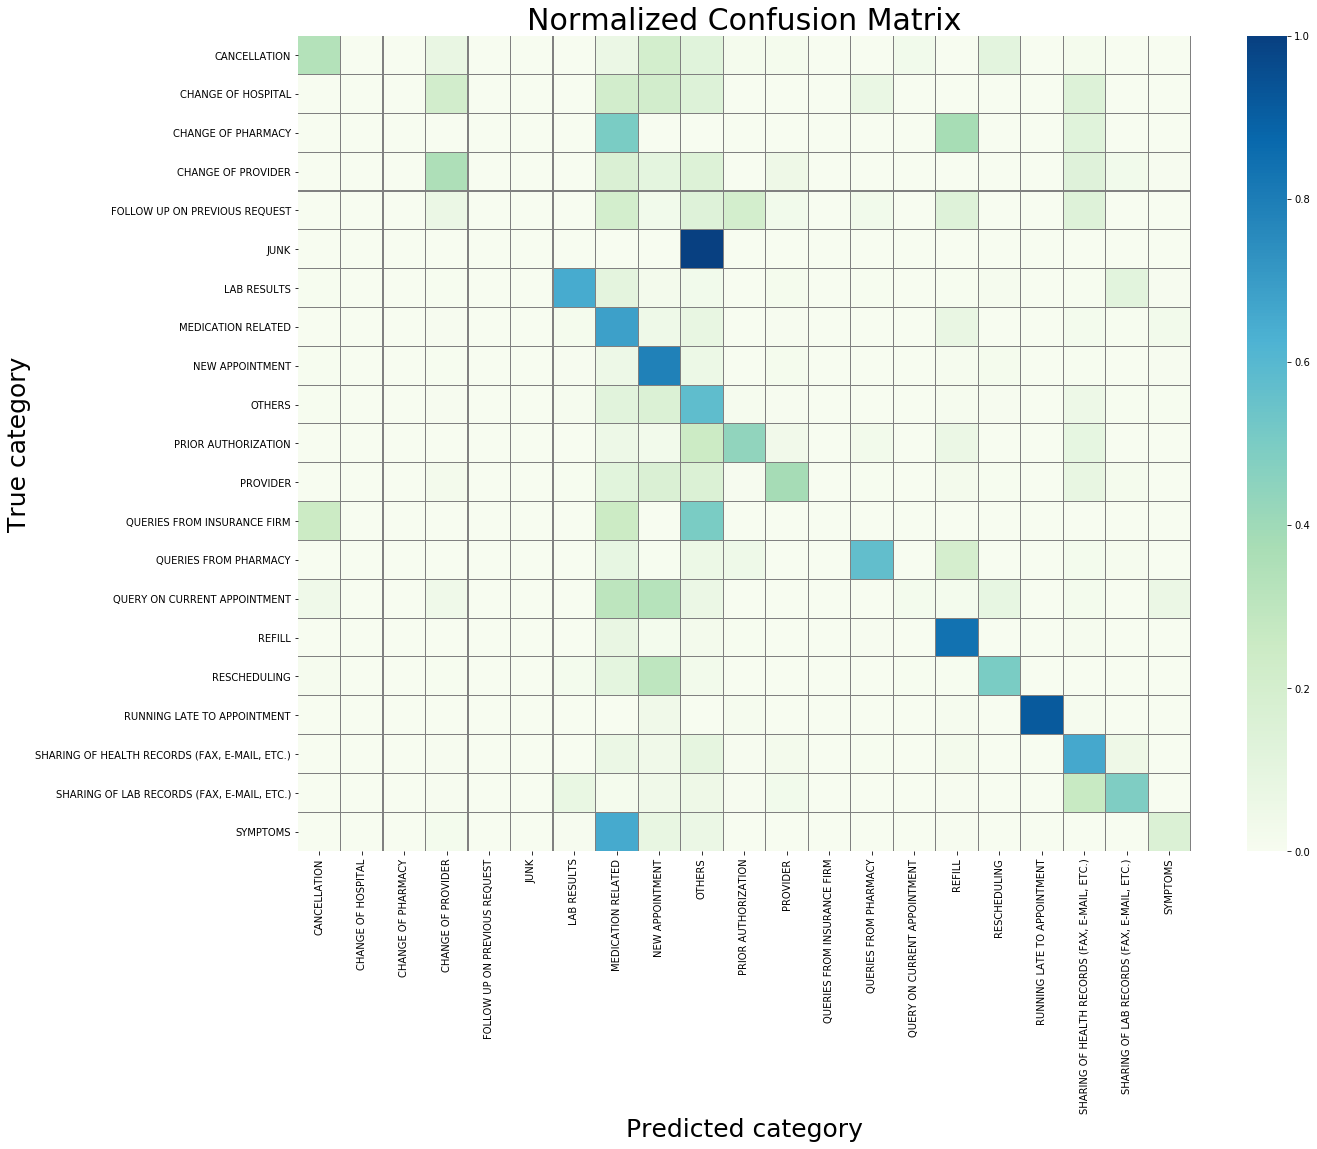

In [51]:
plot_confusion_matrix(model2)

Look at a few predictions that the prediction was wrong.

In [97]:
def concat_prediction(prediction_model):
    predicted_label = encoder.inverse_transform(prediction_model.predict(X_test))
    df_diff_model = df_y_test[df_y_test != predicted_label]
    df_y_compare = pd.concat([df_y_test, pd.Series(predicted_label, index=df_y_test.index)], axis=1)

    for i in list(df_diff_model.index[:10]):
        print(i)
        print(df_X_test.loc[i])
        print('Actual label:' + df_y_test.loc[i])
        print("Predicted label: " + df_y_compare[0].loc[i])
        print("\n")    

In [100]:
print("Look at 10 wrong predictions:")
concat_prediction(model2)

Look at 10 wrong predictions:
38239
lm mom let know need letter state glafira income pm lisa mohamed rn mom come patient assistant paperwork vimpat know must give letter say income would go speak go ahead fax patient assistance paperwork last week ucb without letter know receive need mom time tell also go tell mom next time able help without spanish interpreter
Actual label:OTHERS
Predicted label: SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)


3745
wife return phone wife say wait name spouse appointment wife state someone wife say wasnt rna shes upset bc shes impression someone office say patient driving labtype wife still wouldnt say regard labtype wife request work appointment wgf refuse see np prior authorization rna follow lmo ident vm tcb discuss jennifer taylor rn rna follow rc wife please mary gryder rna follow lmo ident vm tcb discuss spot block w wgf family member jennifer taylor rn wife return phone wife say wait next week patient see doctor
Actual label:NEW APPOINTMENT
Pred

From the confusion matrix I conclude that the model is making reasonable predictions. Now we try RNN LSTM. 

In [93]:
print('Building model, RNN LSTM...')

model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_converse_length))
model3.add(LSTM(64)) # try 100
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, \
                      batch_size=batch_size, \
                      epochs=epochs, \
                      verbose=1, \
                      validation_split=0.1)

score = model3.evaluate(X_test, y_test, \
                        batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Building model, RNN LSTM...
Train on 39446 samples, validate on 4383 samples
Epoch 1/16
39446/39446 [==============================] - 505s 13ms/step - loss: 1.6768 - acc: 0.4885 - val_loss: 1.3064 - val_acc: 0.5966
Epoch 2/16
39446/39446 [==============================] - 496s 13ms/step - loss: 1.1156 - acc: 0.6566 - val_loss: 1.0685 - val_acc: 0.6612
Epoch 3/16
39446/39446 [==============================] - 495s 13ms/step - loss: 0.9110 - acc: 0.7149 - val_loss: 0.8971 - val_acc: 0.7102
Epoch 4/16
39446/39446 [==============================] - 488s 12ms/step - loss: 0.7927 - acc: 0.7454 - val_loss: 0.8477 - val_acc: 0.7308
Epoch 5/16
39446/39446 [==============================] - 488s 12ms/step - loss: 0.7192 - acc: 0.7667 - val_loss: 0.8256 - val_acc: 0.7337
Epoch 6/16
39446/39446 [==============================] - 486s 12ms/step - loss: 0.6609 - acc: 0.7831 - val_loss: 0.8339 - val_acc: 0.7349
Epoch 7/16
39446/39446 [==============================] - 487s 12ms/step - loss: 0.6097 -

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


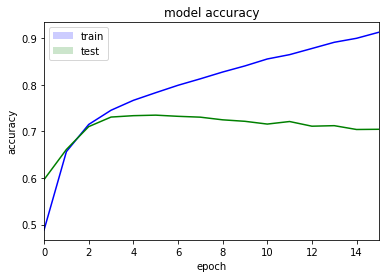

In [94]:
summarize_history(history3)

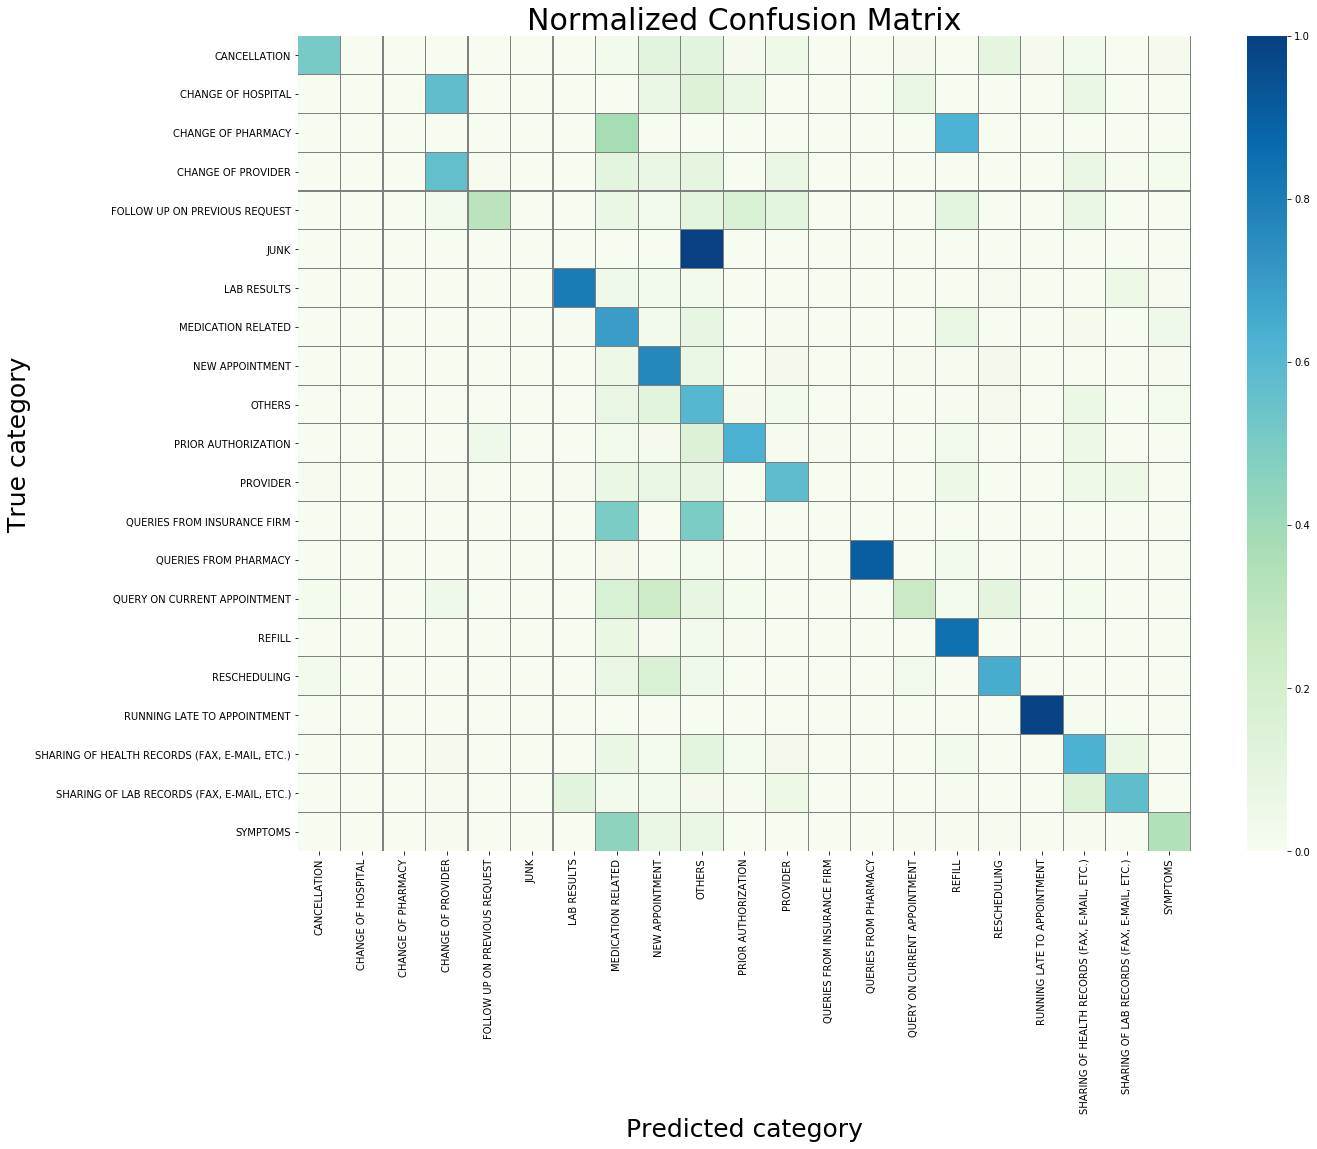

In [95]:
plot_confusion_matrix(model3)

In [99]:
print("Look at 10 wrong predictions:")
concat_prediction(model3)

Look at 10 wrong predictions:
45474
letter faa regard cpap labtype sleep apnea patient call need letter faa say cpap labtype sleep apnea please patient timephrase discuss rna follow spoke patient suggest need schedule iov see seven year say check see need appointment write letter need yeh dont really consider patient havent see year overly accomodating sight unseen alternativ presumably see recently write letter atp rna follow iov notify read
Actual label:SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Predicted label: PROVIDER


38239
lm mom let know need letter state glafira income pm lisa mohamed rn mom come patient assistant paperwork vimpat know must give letter say income would go speak go ahead fax patient assistance paperwork last week ucb without letter know receive need mom time tell also go tell mom next time able help without spanish interpreter
Actual label:OTHERS
Predicted label: SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)


3745
wife return phone wife say wait name spous